## Семинар 8: "LSTM"

ФИО: Ира Букреева

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_sequence, pad_packed_sequence
from IPython.display import clear_output
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        
        h, c = hidden
        bs = h.size(0)
        
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.
С помощью обученной сети получить из train-части временного ряда test-часть.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

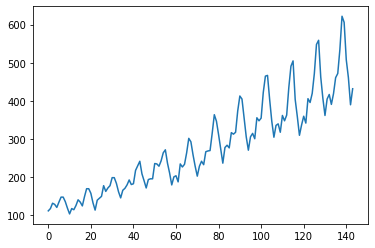

In [82]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [83]:
# подготовливаем данные
dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [84]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size:], dataset[train_size - 30:train_size:]
print(len(train), len(test))

96 30


In [85]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [86]:
# Пример подготовленных данных

#seems like 30 is the best
look_back = 30
# look_forward=1
trainX, trainY = create_dataset(train, look_back)#, look_forward)

In [87]:
train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))

In [88]:
train_dataloader =  DataLoader(train_dataset, batch_size=30)

### LSTMModel

In [94]:
class LSTMModel(nn.Module):
    
    def __init__(self, model, hidden_size):
        if not model==nn.LSTM and not model==LSTM:
            raise TypeError("invalid type")
        super(LSTMModel, self).__init__()
        self.num_layers = 1 # we use just one layer
        self.hidden_size = hidden_size
        self.model = model(1, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, 1)
    
    def forward(self, inp):
        if self.model.__class__ == torch.nn.modules.rnn.LSTM:
            batch_size = inp.size(0)
            self.hidden = (torch.zeros(self.num_layers, batch_size, 
                                   self.hidden_size, requires_grad=True),
                       torch.zeros(self.num_layers, batch_size, 
                                   self.hidden_size, requires_grad=True))
            inp = pack_sequence(inp)
            lstm_out, self.hidden = self.model(inp, self.hidden)
            lstm_out, _ = pad_packed_sequence(lstm_out, False)
            
        else: # self.model==LSTM
            batch_size = inp.size(1)
            hidden = (Variable(torch.zeros(batch_size, self.hidden_size)),
                    Variable(torch.zeros(batch_size, self.hidden_size)))
        
            lstm_out, self.hidden = self.model(inp, hidden)
        
        
        lstm_out = lstm_out[-1]
        out = self.linear(lstm_out.view(batch_size, self.hidden_size))
        return out

In [104]:
def trainfunc(network, train_loader, epochs, learning_rate):
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    try:
        for epoch in range(epochs):
            
            losses = []
            
            for X, y in train_loader:
                network.zero_grad() 
                X_train = torch.FloatTensor(X).view(-1, look_back, 1) # nn.LSTM
                y_train = torch.FloatTensor(y).view(-1, 1)
                prediction = network(X_train)
#                 X_train = Variable(X.permute(1,0).unsqueeze(-1))  #LSTM
#                 y_train = Variable(y)
#                 prediction = network(X_train).squeeze()
                
                loss_b = loss(prediction, y_train)
                losses.append(loss_b.data.item())
                loss_b.backward()
                optimizer.step()
            train_loss_epochs.append(np.mean(losses))   
    except KeyboardInterrupt:
        raise KeyboardInterrupt
    return train_loss_epochs

In [105]:
def predict(model, testX):
    preds = []
    for i in range(test_size):
        y_test = model(testX)
        preds.append(y_test[-1].detach().numpy()[0])
        testX = torch.cat((testX[:,1:,:], y_test.view(1, 1, 1)), 1)  #nn.LSTM
#         testX = torch.cat((testX[1:,:,:], y_test.view(1, 1, 1)), 0) #LSTM
    return preds

### LSTM

In [97]:
lstm = LSTMModel(LSTM, 10)
train_loss_epochs = trainfunc(lstm, train_dataloader, 1000, 0.005)

In [98]:
X_test = torch.from_numpy(test).view(look_back, 1, 1)
predictions = predict(lstm, X_test)

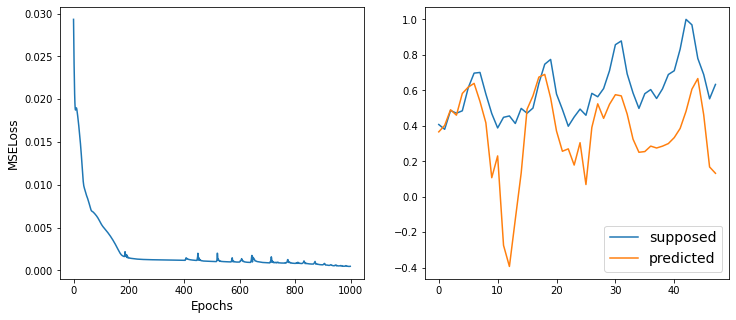

In [99]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_epochs)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('MSELoss', fontsize=12)

plt.subplot(1, 2, 2)
supposed = dataset[train_size:len(dataset):]
plt.plot(supposed, label='supposed')
plt.plot(predictions, label='predicted')
plt.legend(fontsize=14)
plt.show()

### nn.LSTM

In [106]:
lstm = LSTMModel(nn.LSTM, 10)
train_loss_epochs = trainfunc(lstm, train_dataloader, 800, 0.01)

In [107]:
X_test = torch.from_numpy(test).view(1, look_back, 1)
predictions = predict(lstm, X_test)

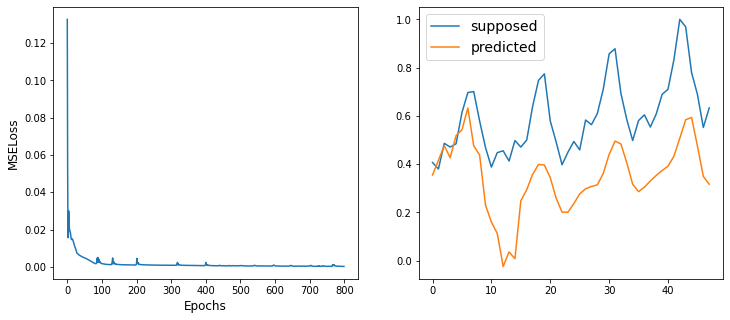

In [108]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_epochs)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('MSELoss', fontsize=12)

plt.subplot(1, 2, 2)
supposed = dataset[train_size:len(dataset):]
plt.plot(supposed, label='supposed')
plt.plot(predictions, label='predicted')
plt.legend(fontsize=14)
plt.show()